In [9]:
import numpy as np
import matplotlib.pyplot as plt


In [10]:
def conv_sp(bits, p):
    '''
    converte sério-paraleleo, agrupando de p em p
    '''
    return np.reshape(bits, (int(len(bits)/p), p))


def get_key(val): 
    '''
    retorna o numero da sequencia conforme tabela
    '''
    for key, value in symbol_table.items(): 
         if np.array_equal(val,value): 
            return key
    raise KeyError("key não existe:", str(val))
    
    
def toIQ(i, E, M):
     return (np.sqrt(E)*np.cos(2*(i-1)*(np.pi/M)), 
             np.sqrt(E)*np.sin(2*(i-1)*(np.pi/M)))
    
def freq_shift(s, fc, t):
    '''
    adiciona defasamento no sinal, se acordo com sua posição na constelação
    '''
    r1 = s[0]*np.sqrt(2/t[-1])*np.cos(2*np.pi*fc*t)
    r2 = s[1]*np.sqrt(2/t[-1])*np.sin(2*np.pi*fc*t)
    return r1+r2

def viz_modulation(t, signal, T_s, name:str):
    #Visualização do sinal no tempo e na frequência
    plt.figure(num=1,figsize=(20,7))
    plt.plot(t, signal)
    plt.title(f"Modulação {name}")
    plt.ylabel("Amplitude (V)")
    plt.xlabel("time (s)")

    S = np.fft.fft(signal)
    n = np.fft.fftfreq(S.size, d=t[1])
    plt.figure(num=2)
    plt.plot(n[0:int(n.size/32)], abs(S[0:int(S.size/32)]))
    plt.ylabel("|S(w)|")
    plt.xlabel("frequency (Hz)")

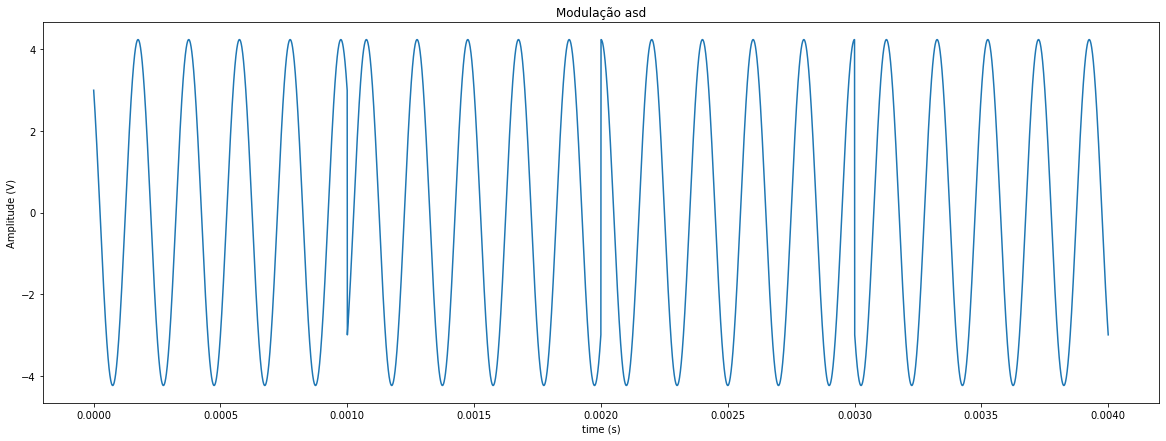

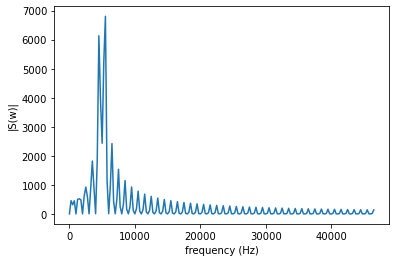

In [11]:
E = 0.009  #energia do sinal  W.s
fc = 5e3   #freq da portadora em Hz
T_s = 1e-3  #intervalo de bit em s

num_amostras_por_bit = 500

symbol_table = {
    1: [1,1,1],
    2: [1,1,0],
    3: [0,1,0],
    4: [0,1,1],
    5: [0,0,1],
    6: [0,0,0],
    7: [1,0,0],
    8: [1,0,1],
}
M = len(symbol_table)
p = int(np.log2(M))
angles_table = {}
for i in symbol_table:
    angles_table[i] = 2*np.pi/M*(i-1)
    
################
s = [1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0] #np.random.randint(2, size=12)

# Bits to symbols
s_groups = conv_sp(s, p)
s_symbols = [get_key(bit_group) for bit_group in s_groups]

# Symbols to IQ
s_IQ = [toIQ(symbol, E, M) for symbol in s_symbols]

# IQ to signal
ts = np.linspace(0, T_s, num_amostras_por_bit*p)
s_modulated = np.array([freq_shift(IQ, fc, ts) for IQ in s_IQ]).flatten()

t = np.linspace(0, T_s*s_groups.shape[0], np.array(s_modulated).size)
viz_modulation(t, s_modulated, T_s, 'asd')

# Demodulação - Não funciona

In [12]:
from scipy.integrate import simps

In [19]:
num_amostras_por_bit = 1500
s_demodulated = []
last = 1
for x in range(0, s_modulated.shape[0], num_amostras_por_bit):
    #corr phi1
    f = lambda t: np.sqrt(2/T_s)*np.cos((2*np.pi/T_s)*t)
    X = simps(s_modulated[x:x+num_amostras_por_bit]*f(t[x:x+num_amostras_por_bit]), t[x:x+num_amostras_por_bit])

    #corr phi2
    f = lambda t: np.sqrt(2/T_s)*np.sin((2*np.pi/T_s)*t)
    Y = simps(s_modulated[x:x+num_amostras_por_bit]*f(t[x:x+num_amostras_por_bit]), t[x:x+num_amostras_por_bit])

    # Identify symbol
    phi = np.arctan(Y/X)
    if phi<0:
        phi += 2*np.pi
        
    nearest = None
    distance = np.inf
    for angle in angles_table:
        d = np.min([ np.abs(phi - angles_table[angle]) , np.abs(phi - angles_table[angle] - 360) ])
        if d<distance:
            nearest = angle
            distance = d
    print(phi, nearest)
    s_demodulated += symbol_table[nearest]
    last = nearest
print('Demodulated sequence:', s_demodulated)
print('Original sequence:   ', s)

4.907864937641153 7
4.908912309754368 7
0.0005236860567950656 1
1.375320369534651 3
Demodulated sequence: [1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0]
Original sequence:    [1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0]
